## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In [ ]:
import pandas as pd

df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')

In [ ]:
df.head()
phishing_emails = df[df['Email Type'] == 'Phishing Email']
phishing_emails
tokens = phishing_emails['Email Text'].str.split()
tokens

3        [Hello, I, am, your, hot, lil, horny, toy., I,...
4        [software, at, incredibly, low, prices, (, 86,...
7        [entourage, ,, stockmogul, newsletter, ralph, ...
8        [we, owe, you, lots, of, money, dear, applican...
10       [make, her, beg, you, to, give, it, to, her, e...
                               ...                        
18618    [congratulations, you, have, won, !, !, !, pls...
18621                                              [empty]
18622    [strong, buy, alert, :, monthly, newsletter, t...
18629    [date, a, lonely, housewife, always, wanted, t...
18633                                              [empty]
Name: Email Text, Length: 7312, dtype: object

__In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.__

There are sort of two paths that I can see myself going before I run a predictive algorithm:
1. For each email, I would compare which words come up the most often excluding articles and compare phrases or many words across the different emails. With these phrases or sets of words, I would one-hot-encode the sets.
2. For all the emails, I would aggregate them into a single vector and examine which words come up the most often excluding articles (a, the, etc.). With the most common tokens, I would one-hot-encode the words.

Then, I would probably run PCA since they use the presence of tokens to classify (evaluate whether emails are a scam).

### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [ ]:
import pickle
with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

In [ ]:
token_freq_table = pd.DataFrame(token_freq,columns=['token','count'])
token_freq_table

,token,count
0,new,1365
1,date,1202
2,get,1052
3,please,1022
4,enron,927
...,...,...
48686,truck[1].,1
48687,"feet,",1
48688,housewifes,1
48689,dorn,1


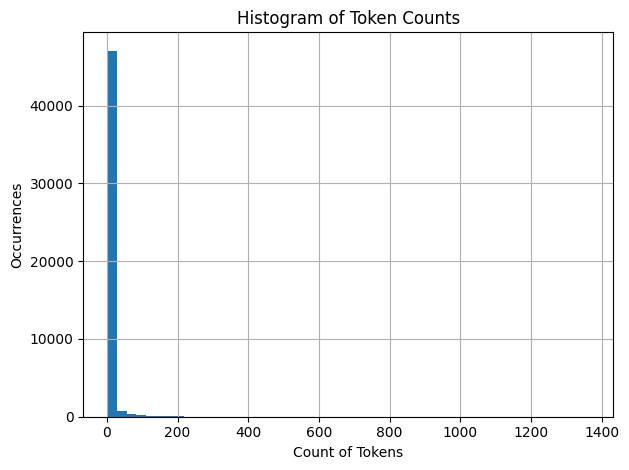

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#token_freq_table['log_count'] = np.log(token_freq_table['count'])
(token_freq_table['count']).hist(bins=50)
plt.xlabel('Count of Tokens')
plt.ylabel('Occurrences')
plt.title('Histogram of Token Counts')

# Show the plot
plt.tight_layout()
plt.show()

**What do you notice about the frequency of occurrence of different tokens? How does it look?**


There is a lot of tokens that appear a lot, but there are so many occurances of the first bin (token appears less than 50 times in all of the emails) that we cannot see those bins that have more occurances.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_parquet('Phishing_clean.parquet')

y = df['Email Type']
X = df.drop('Email Type',axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=125)


In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

model = LinearRegression(fit_intercept=False).fit(X_train,y_train)
y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print('train: ', r2_score(y_hat_train,y_train) )
print('test: ', r2_score(y_hat_test,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


In [5]:
import numpy as np
rdf = pd.DataFrame({'variable':model.feature_names_in_ , 'value':model.coef_})
rdf['abs'] = np.abs(rdf['value'])
rdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


**What words have the largest coefficients in absolute value and most strongly influence predictions?**

Although the tokens with the highest frequencies are numbers, scrolling through the value_count list, the next most common words are url, oprah, revamping, fax, and some jargon. Because we split the tokens by spaces and not other punctuation, the results may not be as accurate if all the words were isolated.

Also, the model overfit to the training set, indicated by the negative r2 score, which means that the model is predicting worse than if just the mean was used.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

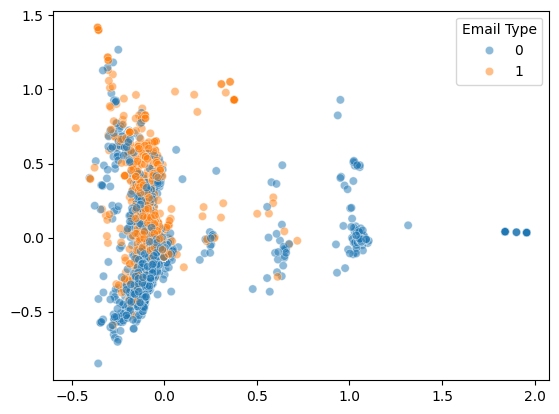

In [12]:
from sklearn.decomposition import PCA
import seaborn as sns

reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test, alpha=0.5)

Email Type 1 are the scams. They tend to be plotted higher on the y-axis (second component) and lower on the x-axis (first component), but there isn't much more of a pattern than that

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [13]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_k = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_k.predict(Z_test)
y_hat_train = lm_k.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

From just the r2 scores alone, we can see that the PCA model did not overfit and was actually able to predict whether the email was a scam or not. PCA helps to reduce the dimensionality of the data while retaining as much of the information as possible, allowing us to focus on the most import datapoints, reducing the impact of noise in the data, and overall better generalize the data's patterns.